In [26]:
from google.colab import files

# Upload kaggle.json (the API key you downloaded)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivamgehlot128","key":"ea79d35349e162c8d01dcd0376058ca5"}'}

In [27]:
import os

# Make a hidden folder for kaggle
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json into the folder
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


In [28]:
!!kaggle datasets download -d fedesoriano/traffic-prediction-dataset



['Dataset URL: https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset',
 'License(s): copyright-authors',
 'traffic-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [29]:
import zipfile
with zipfile.ZipFile("traffic-prediction-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("traffic_data")




In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
df = pd.read_csv("traffic_data/traffic.csv")

print("Shape:", df.shape)
print(df.columns)
print(df.head())

# Optional: convert DateTime column to datetime type
if 'DateTime' in df.columns:
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    print(df['DateTime'].dtypes)

Shape: (48120, 4)
Index(['DateTime', 'Junction', 'Vehicles', 'ID'], dtype='object')
              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
datetime64[ns]


In [31]:
df.head()

,DateTime,Junction,Vehicles,ID,hour,dow,month,is_weekend,hour_sin,hour_cos,lag_1,lag_2,lag_24
24,2015-11-02 00:00:00,1,14,20151102001,0,0,11,False,0.000000,1.000000,15.0,20.0,15.0
25,2015-11-02 01:00:00,1,12,20151102011,1,0,11,False,0.258819,0.965926,14.0,15.0,13.0
26,2015-11-02 02:00:00,1,14,20151102021,2,0,11,False,0.500000,0.866025,12.0,14.0,10.0
27,2015-11-02 03:00:00,1,12,20151102031,3,0,11,False,0.707107,0.707107,14.0,12.0,7.0
28,2015-11-02 04:00:00,1,12,20151102041,4,0,11,False,0.866025,0.500000,12.0,14.0,9.0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48024 entries, 24 to 48119
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DateTime    48024 non-null  datetime64[ns]
 1   Junction    48024 non-null  int64         
 2   Vehicles    48024 non-null  int64         
 3   ID          48024 non-null  int64         
 4   hour        48024 non-null  int32         
 5   dow         48024 non-null  int32         
 6   month       48024 non-null  int32         
 7   is_weekend  48024 non-null  bool          
 8   hour_sin    48024 non-null  float64       
 9   hour_cos    48024 non-null  float64       
 10  lag_1       48024 non-null  float64       
 11  lag_2       48024 non-null  float64       
 12  lag_24      48024 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(5), int32(3), int64(3)
memory usage: 4.3 MB


In [33]:

#  Extract useful time-based features
df['hour'] = df['DateTime'].dt.hour
df['dayofweek'] = df['DateTime'].dt.dayofweek
df['month'] = df['DateTime'].dt.month
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
df['is_peak'] = df['hour'].isin([7,8,9,17,18,19]).astype(int)  # rush hours


In [59]:
df = df.sort_values(["Junction","DateTime"])
df['lag_1'] = df.groupby("Junction")['Vehicles'].shift(1)
df['lag_2'] = df.groupby("Junction")['Vehicles'].shift(2)
df['lag_3'] = df.groupby("Junction")['Vehicles'].shift(3)

In [60]:
print("Missing values:\n", df.isnull().sum())


Missing values:
 DateTime       0
Junction       0
Vehicles       0
ID             0
hour           0
dow            0
month          0
is_weekend     0
hour_sin       0
hour_cos       0
lag_1          4
lag_2          8
lag_24         0
dayofweek      0
is_peak        0
lag_3         12
dtype: int64


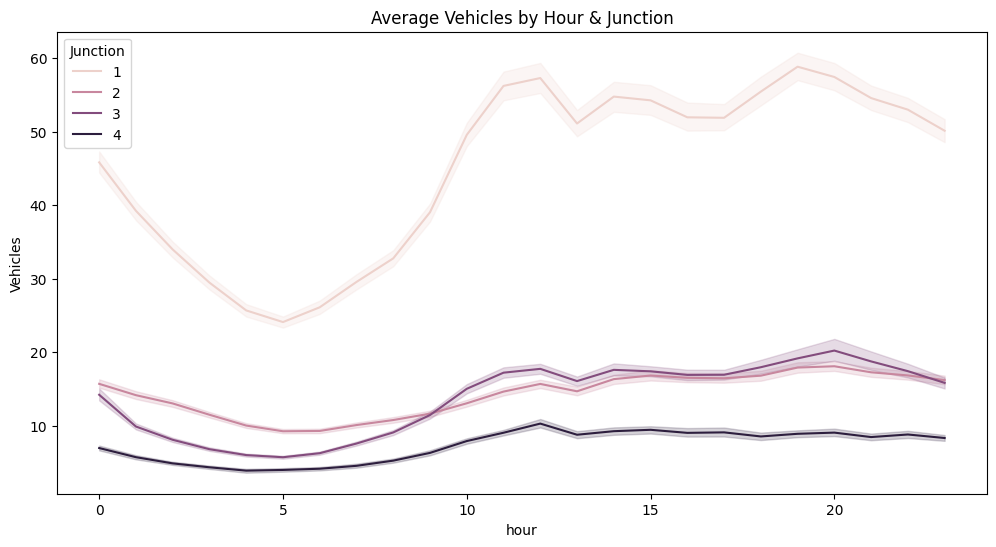

In [61]:
plt.figure(figsize=(12,6))
sns.lineplot(x="hour", y="Vehicles", hue="Junction", data=df)
plt.title("Average Vehicles by Hour & Junction")
plt.show()

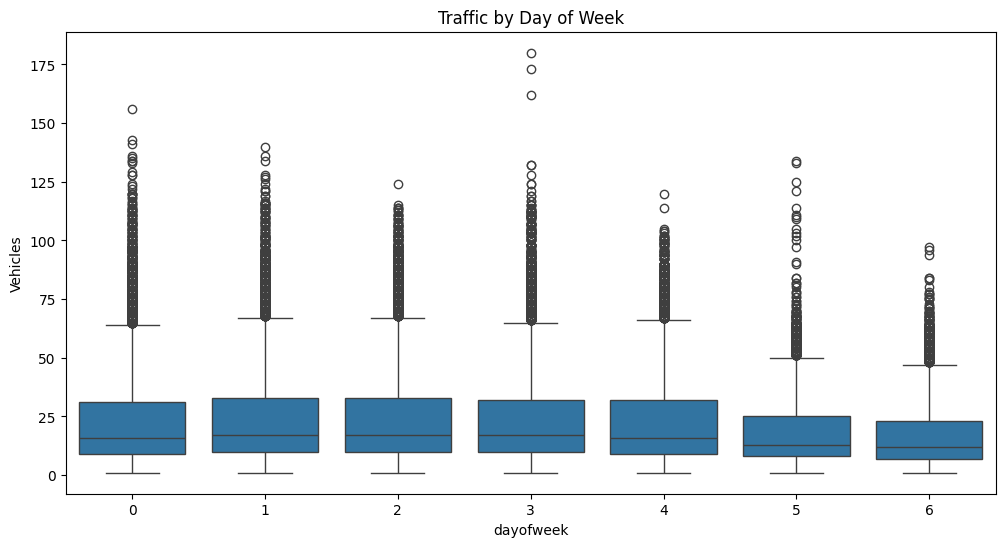

In [62]:
plt.figure(figsize=(12,6))
sns.boxplot(x="dayofweek", y="Vehicles", data=df)
plt.title("Traffic by Day of Week")
plt.show()

In [63]:
df = df.dropna()


In [39]:
features = ['hour', 'dayofweek', 'month', 'is_weekend', 'is_peak', 'lag_1', 'lag_2', 'lag_3']
target = 'Vehicles'

In [40]:
X = df[features]
y = df[target]


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [42]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [43]:
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8
}


In [64]:
model = xgb.train(params, dtrain, num_boost_round=200)

In [65]:
y_pred = model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [66]:
print("RMSE:", rmse)
print("R2 Score:", r2)

RMSE: 4.72090029196237
R2 Score: 0.7756671905517578


In [67]:
def predict_future(hours=24):
    future_predictions = []
    for junc in df['Junction'].unique():
        future = pd.date_range(start=df['DateTime'].max() + pd.Timedelta(hours=1),
                               periods=hours, freq="H")
        fdf = pd.DataFrame({"DateTime": future})
        fdf['hour'] = fdf['DateTime'].dt.hour
        fdf['dayofweek'] = fdf['DateTime'].dt.dayofweek
        fdf['month'] = fdf['DateTime'].dt.month
        fdf['is_weekend'] = fdf['dayofweek'].isin([5,6]).astype(int)
        fdf['is_peak'] = fdf['hour'].isin([7,8,9,17,18,19]).astype(int)

        # use last known values for lags
        last_row = df[df['Junction']==junc].iloc[-1]
        fdf['lag_1'] = last_row['Vehicles']
        fdf['lag_2'] = last_row['lag_1']
        fdf['lag_3'] = last_row['lag_2']
        fdf['Junction'] = junc

        dfuture = xgb.DMatrix(fdf[features])
        fdf['predicted_vehicles'] = model.predict(dfuture)

        future_predictions.append(fdf)

    return pd.concat(future_predictions)

future_df = predict_future(hours=24)
print(future_df.head())


             DateTime  hour  dayofweek  month  is_weekend  is_peak  lag_1  \
0 2017-07-01 00:00:00     0          5      7           1        0     78   
1 2017-07-01 01:00:00     1          5      7           1        0     78   
2 2017-07-01 02:00:00     2          5      7           1        0     78   
3 2017-07-01 03:00:00     3          5      7           1        0     78   
4 2017-07-01 04:00:00     4          5      7           1        0     78   

   lag_2  lag_3  Junction  predicted_vehicles  
0   84.0   90.0         1           69.674950  
1   84.0   90.0         1           63.448338  
2   84.0   90.0         1           61.672798  
3   84.0   90.0         1           65.728912  
4   84.0   90.0         1           70.486557  


/tmp/ipython-input-2941749846.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future = pd.date_range(start=df['DateTime'].max() + pd.Timedelta(hours=1),
/tmp/ipython-input-2941749846.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future = pd.date_range(start=df['DateTime'].max() + pd.Timedelta(hours=1),
/tmp/ipython-input-2941749846.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future = pd.date_range(start=df['DateTime'].max() + pd.Timedelta(hours=1),
/tmp/ipython-input-2941749846.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future = pd.date_range(start=df['DateTime'].max() + pd.Timedelta(hours=1),


In [69]:
def best_times_A_to_B(A, B, travel_time=1, top_k=5):
    pred_A = future_df[future_df['Junction']==A].copy()
    pred_B = future_df[future_df['Junction']==B].copy()

    # shift B's DateTime for travel delay
    pred_B['DateTime'] = pred_B['DateTime'] - pd.Timedelta(hours=travel_time)

    merged = pd.merge(pred_A, pred_B, on="DateTime", suffixes=("_A","_B"))
    merged['score'] = merged['predicted_vehicles_A'] + merged['predicted_vehicles_B']

    best_slots = merged.sort_values('score').head(top_k)
    print(f"\n🚗 Top {top_k} best time slots from Junction {A} → {B}:")
    print(best_slots[['DateTime','predicted_vehicles_A','predicted_vehicles_B','score']])


# Example usage
best_times_A_to_B(2,4,travel_time=1,top_k=5)


🚗 Top 5 best time slots from Junction 2 → 4:
             DateTime  predicted_vehicles_A  predicted_vehicles_B      score
3 2017-07-01 03:00:00             21.739147             11.312385  33.051533
2 2017-07-01 02:00:00             22.186886             10.988175  33.175060
1 2017-07-01 01:00:00             22.507784             11.077929  33.585712
4 2017-07-01 04:00:00             21.915581             11.960488  33.876068
0 2017-07-01 00:00:00             27.805454             11.137856  38.943310


In [78]:
df["lag_24"] = df.groupby("Junction")["Vehicles"].shift(24)
df["lag_168"] = df.groupby("Junction")["Vehicles"].shift(24*7)  # 1 week lag



In [79]:
for window in [6, 12, 24]:
    df[f"rolling_mean_{window}"] = df.groupby("Junction")["Vehicles"].shift(1).rolling(window).mean()
    df[f"rolling_std_{window}"] = df.groupby("Junction")["Vehicles"].shift(1).rolling(window).std()


In [80]:
df["hour_sin"] = np.sin(2 * np.pi * df["hour"]/24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"]/24)

df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"]/7)
df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"]/7)


In [81]:
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)
print("LightGBM R²:", lgb_model.score(X_test, y_test))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1204
[LightGBM] [Info] Number of data points in the train set: 38486, number of used features: 12
[LightGBM] [Info] Start training from score 25.341501
LightGBM R²: 0.7754927159836401


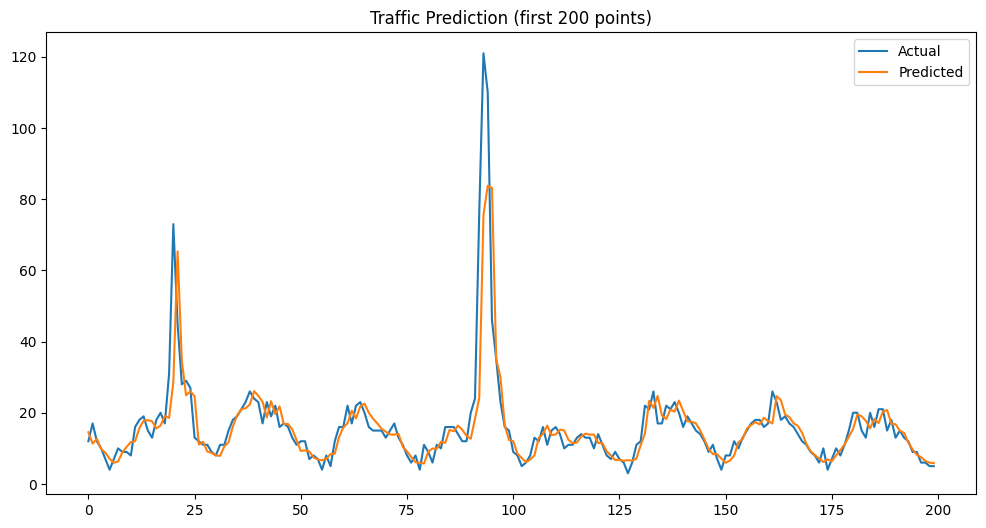

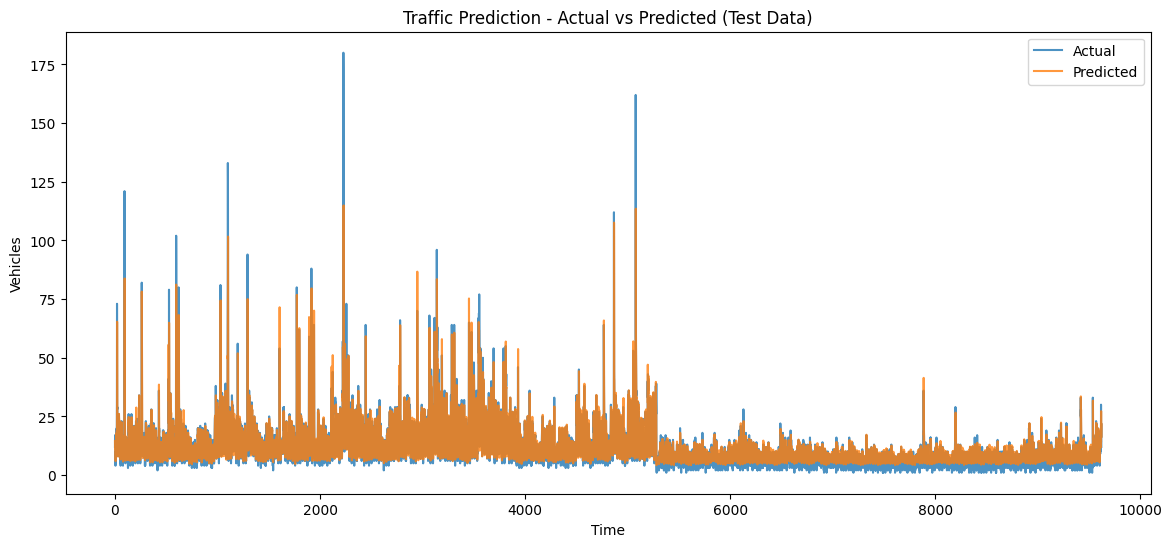

In [84]:
plt.figure(figsize=(14,6))
plt.plot(y_test.values, label="Actual", alpha=0.8)
plt.plot(y_pred, label="Predicted", alpha=0.8)
plt.legend()
plt.title("Traffic Prediction - Actual vs Predicted (Test Data)")
plt.xlabel("Time")
plt.ylabel("Vehicles")
plt.show()